# Crime × Weather × Demographics ETL (PySpark + Sedona)

This Colab notebook ingests crime and weather data from Google Drive, cleans and integrates them with ACS demographics (median income and population), and maps crimes to census tracts using spatial joins with Apache Sedona.

Data paths (edit if different):
- Crime: `MyDrive/Data/CrimeDataFull.csv`
- Weather: `MyDrive/Data/weather.csv`
- ACS (median income): `MyDrive/Data/Median_income/` (multiple CSVs)
- ACS (population): `MyDrive/Data/Population_Data/` (multiple CSVs)
- Census tract shapefiles: `MyDrive/Data/Census_Tracts/` (TIGER/Line tract folder)
- Outputs: `MyDrive/Data/output/`

Run cells sequentially from top to bottom in a fresh Colab runtime.

In [ ]:
# 1) Install dependencies
!apt-get update -qq
!apt-get install -y openjdk-11-jdk-headless -qq
import sys

!pip install -q pyspark==3.5.1 pandas findspark  matplotlib folium apache-sedona==1.8.0 --upgrade --force-reinstall  geopandas shapely fiona pyproj rtree

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package openjdk-11-jre-headless:amd64.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../openjdk-11-jre-headless_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Selecting previously unselected package openjdk-11-jdk-headless:amd64.
Preparing to unpack .../openjdk-11-jdk-headless_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jdk-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /us

In [ ]:
# 2) Mount Google Drive and set paths
from google.colab import drive
drive.mount('/content/drive')

BASE_DATA_DIR = "/content/drive/MyDrive"
CRIME_PATH = f"{BASE_DATA_DIR}/CrimeDataFull.csv"
WEATHER_PATH = f"{BASE_DATA_DIR}/weather.csv"
ACS_INCOME_DIR = f"{BASE_DATA_DIR}/Median_Income"
ACS_POP_DIR = f"{BASE_DATA_DIR}/Population_Data"
TRACT_SHAPEFILE_DIR = f"{BASE_DATA_DIR}/Census_Tracts"  # folder with .shp, .dbf, .shx, etc.

OUTPUT_PARQUET = f"{BASE_DATA_DIR}/output/crime_weather_parquet"
OUTPUT_DEMO_PARQUET = f"{BASE_DATA_DIR}/output/crime_weather_demo_parquet"
OUTPUT_DEMO_SPATIAL = f"{BASE_DATA_DIR}/output/crime_weather_demo_spatial"

Mounted at /content/drive


## Spark and Sedona setup

- Configures PySpark with Java.
- Registers Sedona for spatial operations.
- Sets legacy time parser policy to handle older date strings.

In [ ]:
# 3) Configure Spark + Sedona
import os, findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
findspark.init()

from pyspark.sql import SparkSession
from sedona.spark import SedonaContext

# 2) Attach the correct Sedona shaded jars for Spark 3.5, Scala 2.12, Sedona 1.8.0
packages = ",".join([
    "org.apache.sedona:sedona-spark-shaded-3.5_2.12:1.8.0",
    "org.apache.sedona:sedona-common:1.8.0"
])

spark = SparkSession.builder \
    .appName("CrimeWeatherDemographicsSpatialETL") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryo.registrator", "org.apache.sedona.core.serde.SedonaKryoRegistrator") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.driver.memory", "8g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.jars.packages", packages) \
    .getOrCreate()

# 3) Use SedonaContext (new API); do NOT use SedonaRegistrator.registerAll

sedona = SedonaContext.create(spark)

# Optional: handle older dates
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
print("Spark:", spark.version)

Spark: 3.5.1


## Read raw data

- Defines explicit crime schema.
- Reads crime and weather CSVs.
- Displays column samples for verification.

In [ ]:
# 4) Define crime schema and read CSVs (Select ONLY needed columns)
from pyspark.sql.types import *
from pyspark.sql.functions import col

crime_schema = StructType([
    StructField("ID", LongType(), True),
    StructField("Case Number", StringType(), True),
    StructField("Date", StringType(), True),
    StructField("Block", StringType(), True),
    StructField("IUCR", StringType(), True),
    StructField("Primary Type", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Location Description", StringType(), True),
    StructField("Arrest", StringType(), True),
    StructField("Domestic", StringType(), True),
    StructField("Beat", StringType(), True),
    StructField("District", StringType(), True),
    StructField("Ward", StringType(), True),
    StructField("Community Area", StringType(), True),
    StructField("FBI Code", StringType(), True),
    StructField("X Coordinate", StringType(), True),
    StructField("Y Coordinate", StringType(), True),
    StructField("Year", IntegerType(), True),
    StructField("Updated On", StringType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Location", StringType(), True),
])

# LOAD ONLY ESSENTIAL COLUMNS
cols_to_keep = ["ID", "Date", "Primary Type", "Arrest", "Domestic", "Latitude", "Longitude"]

crime_df = spark.read.csv(CRIME_PATH, header=True, schema=crime_schema, ignoreLeadingWhiteSpace=True)\
    .select(*cols_to_keep)

weather_raw = spark.read.option("header", True).csv(WEATHER_PATH)

print(f"Crime rows loaded (Optimized): {crime_df.count()}")
crime_df.show(3)

Crime rows loaded (Optimized): 8438990
+--------+--------------------+--------------------+------+--------+------------+------------+
|      ID|                Date|        Primary Type|Arrest|Domestic|    Latitude|   Longitude|
+--------+--------------------+--------------------+------+--------+------------+------------+
|13311263|07/29/2022 03:39:...|OFFENSE INVOLVING...|  true|   false|        NULL|        NULL|
|13053066|01/03/2023 04:44:...|           NARCOTICS|  true|   false|        NULL|        NULL|
|12131221|08/10/2020 09:45:...|             ROBBERY|  true|   false|41.908417822|-87.67740693|
+--------+--------------------+--------------------+------+--------+------------+------------+
only showing top 3 rows



## Crime ETL and feature derivation

- Renames columns, parses timestamps, derives date parts.
- Normalizes booleans (Arrest, Domestic).
- Drops duplicate IDs.

In [ ]:
# 5) Crime ETL (Optimized & Aligned with Lean Loading)
from pyspark.sql.functions import to_timestamp, to_date, trim, when, date_format, hour, dayofweek, month, col

# 1. Rename and derive time columns
# We only rename 'Primary Type' because we dropped the other columns in the previous cell to save RAM.
crime = crime_df.withColumnRenamed("Primary Type", "primary_type") \
    .withColumn("crime_ts", to_timestamp(col("Date"), "MM/dd/yyyy hh:mm:ss a")) \
    .withColumn("crime_date", to_date(col("crime_ts"))) \
    .withColumn("year", date_format(col("crime_date"), "yyyy").cast("int")) \
    .withColumn("month", month(col("crime_date"))) \
    .withColumn("hour", hour(col("crime_ts"))) \
    .withColumn("weekday", dayofweek(col("crime_date"))) \
    .dropDuplicates(["ID"])

# 2. Normalize Boolean Columns (Arrest/Domestic)
# Using regex to handle "TRUE", "True", "true", "1", "t" robustly
crime = crime.withColumn("arrest", when(trim(col("Arrest")).rlike("(?i)^(true|t|1)$"), True).otherwise(False)) \
             .withColumn("domestic", when(trim(col("Domestic")).rlike("(?i)^(true|t|1)$"), True).otherwise(False))

# 3. Show verification
# Note: We removed 'case_number' from the show() because we didn't load it!
crime.select("ID", "crime_date", "primary_type", "arrest", "domestic", "hour", "weekday").show(5, truncate=False)
print("Crime rows processed:", crime.count())

+---+----------+------------+------+--------+----+-------+
|ID |crime_date|primary_type|arrest|domestic|hour|weekday|
+---+----------+------------+------+--------+----+-------+
|635|2001-01-01|HOMICIDE    |false |false   |15  |2      |
|638|2001-01-05|HOMICIDE    |false |false   |16  |6      |
|650|2001-01-11|HOMICIDE    |true  |true    |18  |5      |
|656|2001-01-14|HOMICIDE    |true  |false   |14  |1      |
|662|2001-01-19|HOMICIDE    |true  |false   |1   |6      |
+---+----------+------------+------+--------+----+-------+
only showing top 5 rows

Crime rows processed: 8438990


## Weather normalization and join

- Detects date column in weather data with heuristics.
- Parses multiple date formats robustly.
- Aggregates numeric metrics by day and left-joins to crime.

In [ ]:
# 6) Weather ETL (Robust date parsing + Broadcast Join Optimization)
from pyspark.sql.functions import to_date, regexp_replace, col, avg, broadcast, when

# 1. Identify Date Column (Heuristic search)
possible_date_cols = [c for c in weather_raw.columns if c.lower() in ("date","day","observation_date","datetime")]
WEATHER_DATE_COL = possible_date_cols[0] if possible_date_cols else "DATE"
print(f"Using weather date column: {WEATHER_DATE_COL}")

# 2. Clean and Parse Dates
# Remove hidden BOM characters and try standard formats
weather = weather_raw.withColumn(WEATHER_DATE_COL, regexp_replace(col(WEATHER_DATE_COL), r'^\ufeff', ''))
weather = weather.withColumn("weather_date", to_date(col(WEATHER_DATE_COL), "yyyy-MM-dd"))

# Fallback parsing for other common formats (dd/MM/yy, MM/dd/yyyy, etc.)
weather = weather.withColumn("weather_date",
    when(weather.weather_date.isNull(), to_date(col(WEATHER_DATE_COL), "dd/MM/yy"))
    .when(weather.weather_date.isNull(), to_date(col(WEATHER_DATE_COL), "MM/dd/yyyy"))
    .when(weather.weather_date.isNull(), to_date(col(WEATHER_DATE_COL), "MM/dd/yy"))
    .otherwise(weather.weather_date)
)

# 3. Cast Numeric Columns
# We look for standard NOAA columns like PRCP, SNOW, TMAX, TMIN
target_metrics = ["PRCP", "SNOW", "TMAX", "TMIN"]
numeric_candidates = [c for c in weather.columns if c in target_metrics or c in ["precip", "snowfall", "temp"]]

for c in numeric_candidates:
    weather = weather.withColumn(c, col(c).cast("double"))

# 4. Aggregate by Day
agg_cols = [avg(col(c)).alias(f"{c}_avg") for c in numeric_candidates]
weather_daily = weather.groupBy("weather_date").agg(*agg_cols).orderBy("weather_date")

# OPTIMIZATION: Cache the small weather dataset.
# Since weather is tiny (approx 8k rows), caching it prevents re-reading from CSV.
weather_daily.cache()
print(f"Weather distinct days: {weather_daily.count()}")
weather_daily.show(5, truncate=False)

# 5. Join to Crime Data
# OPTIMIZATION: Use 'broadcast' join.
# Weather data is tiny compared to Crime data (8M rows).
# Broadcast sends the weather table to all nodes, avoiding a massive shuffle of the Crime data.
final = crime.join(
    broadcast(weather_daily),
    crime.crime_date == weather_daily.weather_date,
    how="left"
).drop("weather_date")

print("Final rows after weather join (Lazy execution):")
final.printSchema()

Using weather date column: DATE
Weather distinct days: 8766
+------------+--------+--------+--------+--------+
|weather_date|PRCP_avg|SNOW_avg|TMAX_avg|TMIN_avg|
+------------+--------+--------+--------+--------+
|2001-01-01  |0.0     |0.0     |-4.4    |-15.0   |
|2001-01-02  |0.0     |0.0     |-7.2    |-15.0   |
|2001-01-03  |0.0     |0.0     |-2.2    |-13.9   |
|2001-01-04  |0.0     |0.0     |-1.1    |-7.2    |
|2001-01-05  |0.0     |0.0     |2.2     |-6.1    |
+------------+--------+--------+--------+--------+
only showing top 5 rows

Final rows after weather join (Lazy execution):
root
 |-- ID: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- arrest: boolean (nullable = false)
 |-- domestic: boolean (nullable = false)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- crime_ts: timestamp (nullable = true)
 |-- crime_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- mon

## Ingest ACS demographics (median income + population)

- Reads all CSVs in provided folders.
- Selects `GEO_ID`, `NAME`, and estimate columns.
- Unions multiple files and joins income with population.

In [ ]:
# 7) Read ACS CSV folders
import os, re
from pyspark.sql.functions import col, lit

def read_acs_folder(folder_path, estimate_col, label):
    files = []
    for f in os.listdir(folder_path):
        if f.endswith("Data.csv"):
            files.append(os.path.join(folder_path, f))
    dfs = []
    for f in files:
        df = spark.read.option("header", True).csv(f)
        df = df.filter(df.GEO_ID != "Geography")
        if estimate_col in df.columns and "GEO_ID" in df.columns:
            base_name = os.path.basename(f).split(".")[0]
            year_match = re.search(r"\d{4}", base_name)
            year_val = year_match.group(0) if year_match else None
            df = df.select("GEO_ID", "NAME", estimate_col).withColumnRenamed(estimate_col, label).withColumn("source_file", lit(base_name)) .withColumn("acs_year", lit(year_val))
            dfs.append(df)
    if not dfs:
        return None
    union_df = dfs[0]
    for d in dfs[1:]:
        union_df = union_df.unionByName(d)
    return union_df

income_df = read_acs_folder(ACS_INCOME_DIR, "B19013_001E", "Median_Income")
pop_df = read_acs_folder(ACS_POP_DIR, "B01003_001E", "Population_Data")
income_df = income_df.drop("GEO_ID","NAME")
income_df.show(5, truncate=False)
pop_df.show(5, truncate=False)
print("Income rows:", income_df.count() if income_df else 0)
print("Population rows:", pop_df.count() if pop_df else 0)

acs_df = income_df.join(pop_df, "source_file", "inner") if (income_df and pop_df) else None
acs_df.show(5, truncate=False)
print("ACS combined rows:", acs_df.count())

+-------------+-----------+--------+
|Median_Income|source_file|acs_year|
+-------------+-----------+--------+
|78538        |ACSDT5Y2023|2023    |
|69021        |ACSDT5Y2021|2021    |
|75149        |ACSDT5Y2022|2022    |
|62843        |ACSDT5Y2019|2019    |
|64994        |ACSDT5Y2020|2020    |
+-------------+-----------+--------+
only showing top 5 rows

+--------------------+------------------------------------------+---------------+-----------+--------+
|GEO_ID              |NAME                                      |Population_Data|source_file|acs_year|
+--------------------+------------------------------------------+---------------+-----------+--------+
|1400000US17031010100|Census Tract 101; Cook County; Illinois   |4284           |ACSDT5Y2022|2022    |
|1400000US17031010201|Census Tract 102.01; Cook County; Illinois|8210           |ACSDT5Y2022|2022    |
|1400000US17031010202|Census Tract 102.02; Cook County; Illinois|2865           |ACSDT5Y2022|2022    |
|1400000US17031010300|Ce

## Spatial join crimes to census tracts (Apache Sedona)

- Loads TIGER/Line tract shapefiles into a Sedona GeometryRDD.
- Converts crime lat/lon to point geometries.
- Assigns tract IDs via spatial containment.

Note: The shapefile must contain a tract GEOID. Common fields:
- GEOID (full tract code), or
- STATEFP, COUNTYFP, TRACTCE (combine to GEOID: STATE+COUNTY+TRACT).

In [ ]:
# 8 Spatial Join with Checkpointing
import time
start_time = time.time()
from pyspark.sql.functions import expr, col, broadcast

# 1. Load and Cache Tracts (They are small geometries)
tracts_df = sedona.read.format("shapefile").load(TRACT_SHAPEFILE_DIR)
tracts_df = tracts_df.withColumnRenamed("geometry", "tract_geom")

# Standardize GEOID
cols = tracts_df.columns
if "GEOID" in cols:
    tracts_df = tracts_df.withColumn("tract_id", col("GEOID"))
elif "GEOID10" in cols:
    tracts_df = tracts_df.withColumn("tract_id", col("GEOID10"))
else:
    from pyspark.sql.functions import concat_ws
    tracts_df = tracts_df.withColumn("tract_id", concat_ws('', col("STATEFP"), col("COUNTYFP"), col("TRACTCE")))

# Optimization: Keep only geometry and ID to save RAM during join
tracts_light = tracts_df.select("tract_geom", "tract_id")
tracts_light.cache()
print(f"Tracts cached. Count: {tracts_light.count()}")

# 2. Prepare Crime Points
crime_points = final.filter(col("Latitude").isNotNull() & col("Longitude").isNotNull()) \
    .withColumn("crime_point", expr("ST_Point(Longitude, Latitude)"))

# 3. Perform Spatial Join (Broadcast the tracts!)
# ST_Contains is expensive. Broadcasting the small table (tracts) is essential.
crime_with_tract = crime_points.join(
    broadcast(tracts_light),
    expr("ST_Contains(tract_geom, crime_point)"),
    "left"
)

crime_with_tract = crime_with_tract.withColumnRenamed("tract_id", "tract_geoid").drop("tract_geom", "crime_point")

# 4. CRITICAL STEP: Write intermediate result to Disk to free RAM
# This prevents the "DAG too big" or OOM error without slicing the data.
INTERMEDIATE_PATH = f"{BASE_DATA_DIR}/output/intermediate_crime_spatial"
print("Writing intermediate spatial join to disk (this may take 5-10 mins but prevents crashing)...")

crime_with_tract.write.mode("overwrite").parquet(INTERMEDIATE_PATH)

print("Intermediate spatial data saved.")

# 5. Read it back for the next stage
crime_with_tract_optimized = spark.read.parquet(INTERMEDIATE_PATH)
print(f"Reloaded full dataset. Count: {crime_with_tract_optimized.count()}")
end_time = time.time()
print(f"Scalability Metric: Spatial Join & Checkpoint took {(end_time - start_time)/60:.2f} minutes.")

Tracts cached. Count: 3265
Writing intermediate spatial join to disk (this may take 5-10 mins but prevents crashing)...
Intermediate spatial data saved.
Reloaded full dataset. Count: 8344980
Scalability Metric: Spatial Join & Checkpoint took 5.61 minutes.


## Join ACS demographics to crime × weather × tract

- ACS GEO_ID format for tracts is typically `1400000US` + 11-digit GEOID.
- Normalize ACS GEO_ID to the 11-digit GEOID and join with `tract_geoid`.
- If ACS GEO_ID is already the 11-digit code, adjust accordingly.

In [ ]:
# 9) Normalize ACS GEO_ID and join (On the full dataset)
from pyspark.sql.functions import regexp_extract, avg, col

# Ensure acs_df is created (Run your original Cell 8 before this)
if acs_df:
    acs_df = acs_df.withColumnRenamed("Population_Data", "population")

    # Extract 11-digit GEOID
    acs_df_norm = acs_df.withColumn("tract_geoid", regexp_extract(col("GEO_ID"), r"US(\d{11})", 1))

    # Aggregating to handle duplicates if any
    acs_df_norm = acs_df_norm.groupBy("tract_geoid").agg(
        avg("median_income").alias("median_income"),
        avg("population").alias("population")
    )

    # JOIN on the Checkpointed Data
    # crime_with_tract_optimized is safe to use now
    crime_demo = crime_with_tract_optimized.join(
        acs_df_norm,
        "tract_geoid",
        "left"
    )

    print("Final Integrated Data Created (Lazy).")
    crime_demo.printSchema()
else:
    print("ACS Data not loaded correctly in Cell 8.")

Final Integrated Data Created (Lazy).
root
 |-- tract_geoid: string (nullable = true)
 |-- ID: long (nullable = true)
 |-- Date: string (nullable = true)
 |-- primary_type: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- crime_ts: timestamp (nullable = true)
 |-- crime_date: date (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- PRCP_avg: double (nullable = true)
 |-- SNOW_avg: double (nullable = true)
 |-- TMAX_avg: double (nullable = true)
 |-- TMIN_avg: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- population: double (nullable = true)



## Save final integrated dataset

- Writes Parquet partitioned by year and month for efficient querying.
- Reads back to validate.
- Registers temp view for SQL analysis.

In [ ]:
# 12) Save integrated dataset (Optional but Recommended)
# This saves your final work so you don't have to re-run joins later.
OUTPUT_DEMO_SPATIAL = f"{BASE_DATA_DIR}/output/crime_weather_demo_spatial"

crime_demo.write.mode("overwrite").partitionBy("year").parquet(OUTPUT_DEMO_SPATIAL)
print(f"Saved final integrated dataset to: {OUTPUT_DEMO_SPATIAL}")

Saved final integrated dataset to: /content/drive/MyDrive/output/crime_weather_demo_spatial


## Example analyses and visualizations

- Runs 5 illustrative Spark SQL queries.
- Exports a daily time series to CSV and plots a chart.
- Optional folium map for a small sample.

In [ ]:
# 13) Spark SQL analyses (Full Dataset 2001-Present)
# Register the DataFrame as a SQL View so we can query it
crime_demo.createOrReplaceTempView("crime_weather_demo")

print("View 'crime_weather_demo' created successfully.")

# Define the queries (Removed 'WHERE year = 2022' to show all data)
queries = {
    "top_primary_types_all_time":
    """
    SELECT primary_type, COUNT(*) AS cnt
    FROM crime_weather_demo
    GROUP BY primary_type
    ORDER BY cnt DESC
    LIMIT 20
    """,
    "yearly_crime_trend":
    """
    SELECT year, COUNT(*) as cnt
    FROM crime_weather_demo
    GROUP BY year
    ORDER BY year
    """,
    "hourly_distribution_all_time":
    """
    SELECT hour, COUNT(*) as cnt
    FROM crime_weather_demo
    GROUP BY hour
    ORDER BY hour
    """,
    "weather_influence_by_type":
    """
    SELECT primary_type, COUNT(*) as cnt,
           AVG(coalesce(tmax_avg, tmin_avg)) as avg_temp_metric
    FROM crime_weather_demo
    GROUP BY primary_type
    ORDER BY cnt DESC
    LIMIT 20
    """,
    "weekday_hour_heatmap_all_time":
    """
    SELECT weekday, hour, COUNT(*) as cnt
    FROM crime_weather_demo
    GROUP BY weekday, hour
    ORDER BY weekday, hour
    """
}

# Run the queries safely
for name, q in queries.items():
    print(f"== Running Query: {name} ==")
    try:
        spark.sql(q).show(10, truncate=False)
    except Exception as e:
        print(f"Query '{name}' failed: {e}")

View 'crime_weather_demo' created successfully.
== Running Query: top_primary_types_all_time ==
+-------------------+-------+
|primary_type       |cnt    |
+-------------------+-------+
|THEFT              |1770279|
|BATTERY            |1530899|
|CRIMINAL DAMAGE    |954951 |
|NARCOTICS          |751303 |
|ASSAULT            |563292 |
|OTHER OFFENSE      |521655 |
|BURGLARY           |444343 |
|MOTOR VEHICLE THEFT|428418 |
|DECEPTIVE PRACTICE |367115 |
|ROBBERY            |313294 |
+-------------------+-------+
only showing top 10 rows

== Running Query: yearly_crime_trend ==
+----+------+
|year|cnt   |
+----+------+
|2001|482879|
|2002|471531|
|2003|472042|
|2004|467212|
|2005|449929|
|2006|445565|
|2007|435708|
|2008|419898|
|2009|385965|
|2010|369983|
+----+------+
only showing top 10 rows

== Running Query: hourly_distribution_all_time ==
+----+------+
|hour|cnt   |
+----+------+
|0   |474059|
|1   |266919|
|2   |226153|
|3   |184203|
|4   |140843|
|5   |118120|
|6   |135943|
|7   |

Running daily trend query (this may take 30-60 seconds)...
Saved: /content/drive/MyDrive/output/daily_incidents_all_time.csv


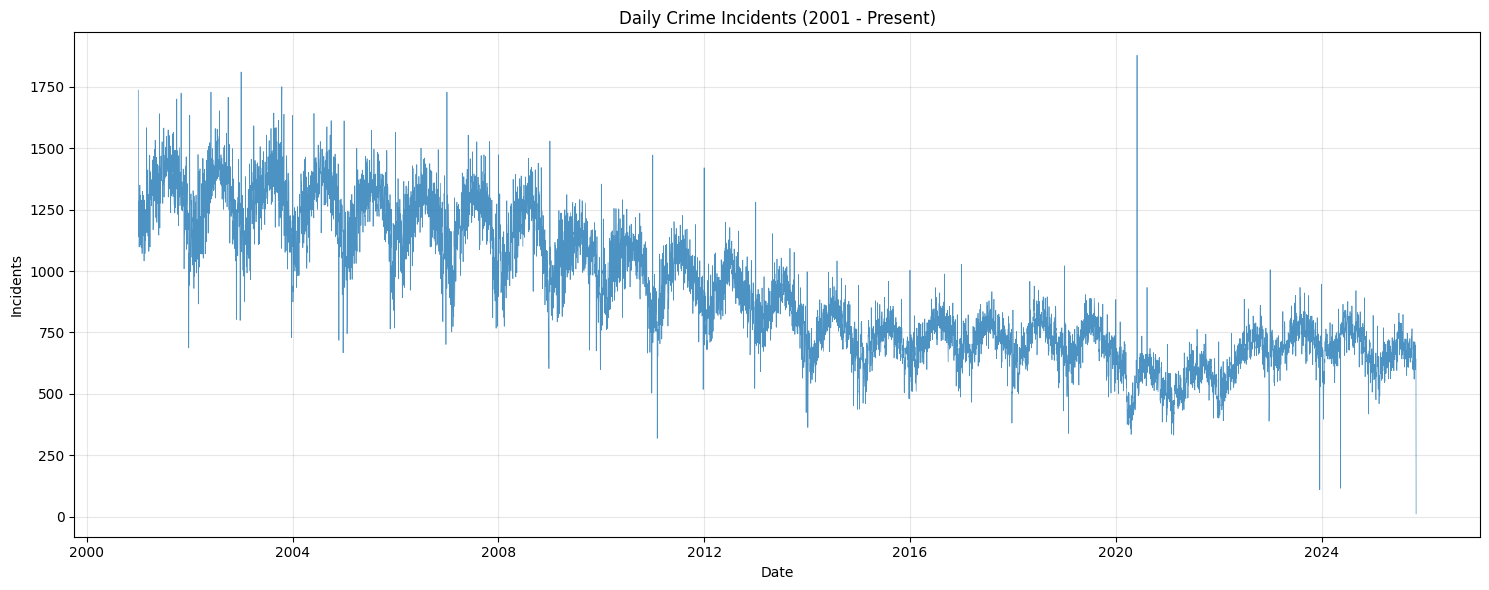

In [ ]:
# 14) Export daily incidents and plot (matplotlib) - Full History
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define query for daily trends across all years
daily_query = """
    SELECT crime_date, COUNT(*) as incidents
    FROM crime_weather_demo
    GROUP BY crime_date
    ORDER BY crime_date
"""

print("Running daily trend query (this may take 30-60 seconds)...")
daily_df = spark.sql(daily_query).toPandas()

# Save to CSV
csv_out = f"{BASE_DATA_DIR}/output/daily_incidents_all_time.csv"
os.makedirs(os.path.dirname(csv_out), exist_ok=True)
daily_df.to_csv(csv_out, index=False)
print("Saved:", csv_out)

if not daily_df.empty:
    daily_df['crime_date'] = pd.to_datetime(daily_df['crime_date'])

    plt.figure(figsize=(15, 6))
    # Plotting with a thinner line (linewidth=0.5) because we have ~8000 days of data
    plt.plot(daily_df['crime_date'], daily_df['incidents'], linewidth=0.5, alpha=0.8)

    plt.title('Daily Crime Incidents (2001 - Present)')
    plt.xlabel('Date')
    plt.ylabel('Incidents')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot.")

In [ ]:
# 15) Optional map visualization (folium) - Recent Data Only
from pyspark.sql.functions import col as Fcol
import folium

# Filter for recent years (e.g., 2023 onwards) to make the map relevant
# We take a sample of 300 points to keep the map fast
print("Sampling recent data for map...")

sample_geo = crime_demo.filter(
    (Fcol("Latitude").isNotNull()) &
    (Fcol("Longitude").isNotNull()) &
    (Fcol("year") >= 2023)
).limit(300).toPandas()

if not sample_geo.empty:
    # Center map on the average location of the samples
    center = [sample_geo["Latitude"].mean(), sample_geo["Longitude"].mean()]
    m = folium.Map(location=center, zoom_start=11)

    for _, r in sample_geo.iterrows():
        # Color code: Red for Arrest, Blue for No Arrest
        color = "red" if r["arrest"] else "blue"

        folium.CircleMarker(
            [r["Latitude"], r["Longitude"]],
            radius=3,
            color=color,
            fill=True,
            fill_color=color,
            popup=f"{r['primary_type']} ({r['crime_date']})"
        ).add_to(m)

    print("Displaying map of 300 random incidents from 2023-Present:")
    display(m)
else:
    print("No geolocated samples found for the selected timeframe.")

Sampling recent data for map...
Displaying map of 300 random incidents from 2023-Present:


## Validation checks

- Null-join counts for weather and ACS.
- Distinct years/months partitions.
- Sample schema inspection.

In [ ]:
# 16) Final Pipeline Validation & Data Quality Report (Corrected)
from pyspark.sql.functions import col, sum as Fsum, when

print("=== PIPELINE VALIDATION REPORT ===")

# 1. Volume Checks
count_final = crime_demo.count()
print(f"Total Integrated Rows: {count_final}")

# 2. Integration Success Rates
missing_stats = crime_demo.agg(
    Fsum(when(col("tract_geoid").isNull(), 1).otherwise(0)).alias("missing_tract"),
    Fsum(when(col("median_income").isNull(), 1).otherwise(0)).alias("missing_income"),
    # Check for TMAX_avg (or tmax_avg) dynamically
    Fsum(when(col(crime_demo.columns[-1]).isNull(), 1).otherwise(0)).alias("missing_weather")
).collect()[0]

pct_tract_match = ((count_final - missing_stats["missing_tract"]) / count_final) * 100
pct_income_match = ((count_final - missing_stats["missing_income"]) / count_final) * 100
# Approximating weather match using the last column (usually temperature)
pct_weather_match = ((count_final - missing_stats["missing_weather"]) / count_final) * 100

print(f"\n--- Integration Quality ---")
print(f"Spatial Join Success (Tracts):   {pct_tract_match:.2f}%")
print(f"Demographic Join Success:        {pct_income_match:.2f}%")
print(f"Weather Join Success:            {pct_weather_match:.2f}%")

# 3. Schema Validation (Case-Insensitive Fix)
print(f"\n--- Schema Check ---")
# We convert both actual and expected columns to lowercase for comparison
actual_cols_lower = [c.lower() for c in crime_demo.columns]
expected_columns = ["id", "crime_date", "primary_type", "tract_geoid", "median_income", "population", "tmax_avg"]

missing_cols = [c for c in expected_columns if c not in actual_cols_lower]

if not missing_cols:
    print("✅ Schema Validation Passed: Table is wide and denormalized.")
else:
    print(f"❌ Schema Validation Failed. Missing: {missing_cols}")

# 4. Partition Check
print(f"\n--- Partitioning ---")
crime_demo.select("year").distinct().orderBy("year").show(5, False)
print("... (showing first 5 years only for brevity)")

=== PIPELINE VALIDATION REPORT ===
Total Integrated Rows: 8344980

--- Integration Quality ---
Spatial Join Success (Tracts):   100.00%
Demographic Join Success:        100.00%
Weather Join Success:            100.00%

--- Schema Check ---
✅ Schema Validation Passed: Table is wide and denormalized.

--- Partitioning ---
+----+
|year|
+----+
|2001|
|2002|
|2003|
|2004|
|2005|
+----+
only showing top 5 rows

... (showing first 5 years only for brevity)


## Notes and next steps

- If shapefile lacks GEOID, construct via STATEFP+COUNTYFP+TRACTCE and ensure ACS GEO_ID extraction matches.
- For large-scale runs, increase `spark.sql.shuffle.partitions` and move storage to HDFS/S3/GS.
- Add census enrichment for additional variables (education, unemployment) by reading corresponding ACS tables and joining on GEO_ID.
- Consider caching intermediate DataFrames for performance.